## Importing Libraries

In [682]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

## Loading the Data

In [683]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [684]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

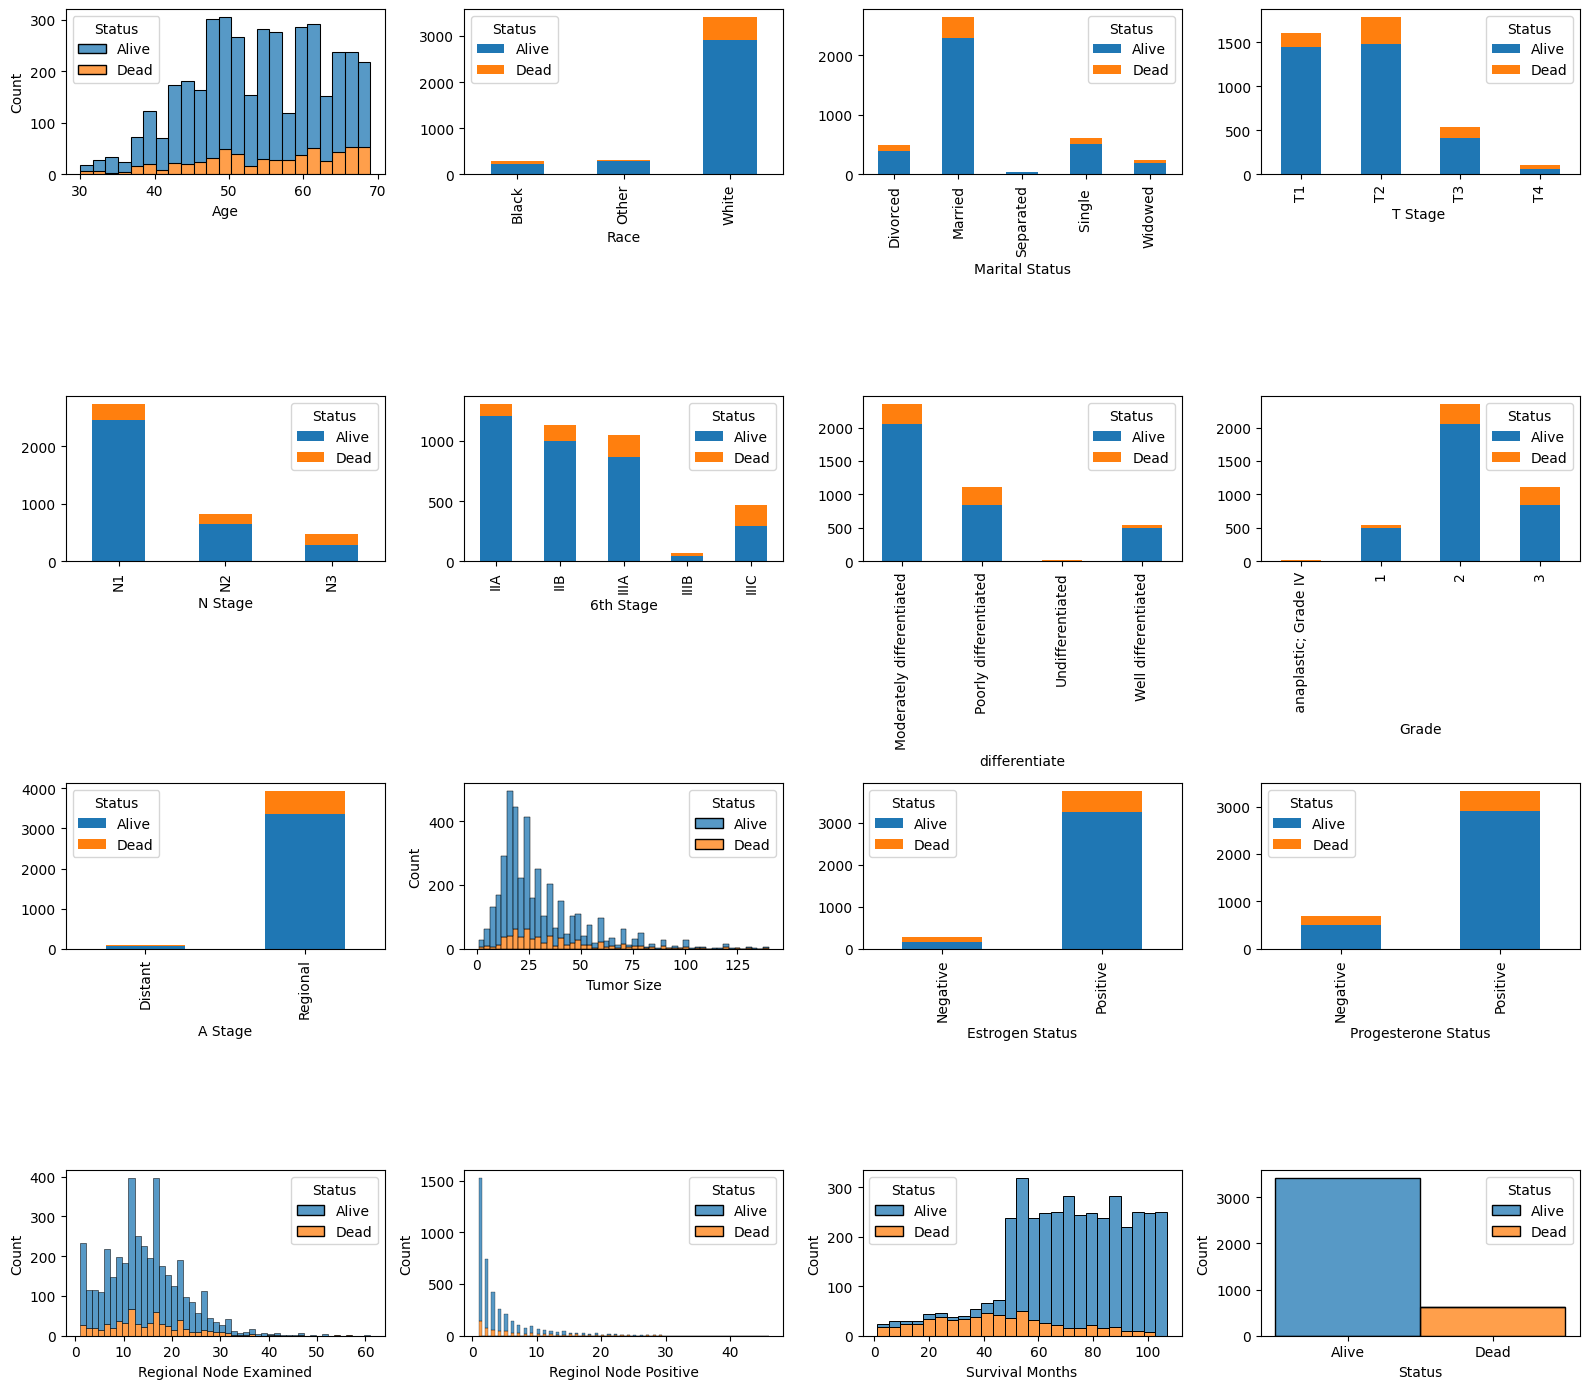

In [685]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

<Axes: >

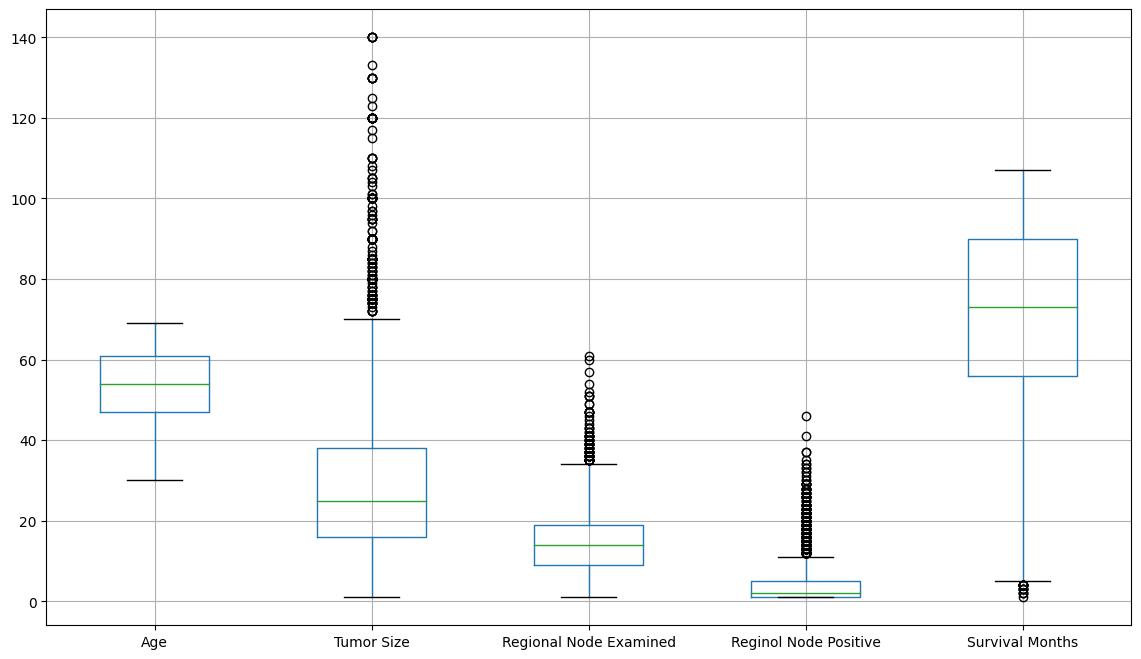

In [686]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8))

## Transformations

<Axes: ylabel='Frequency'>

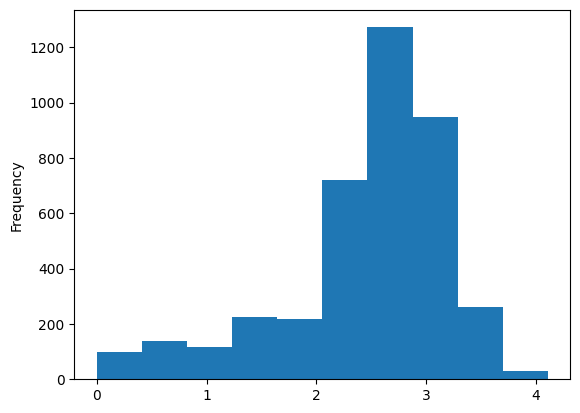

In [687]:
df['Regional Node Examined'] = df['Regional Node Examined'].apply('log')
df['Regional Node Examined'].plot.hist()


<Axes: ylabel='Frequency'>

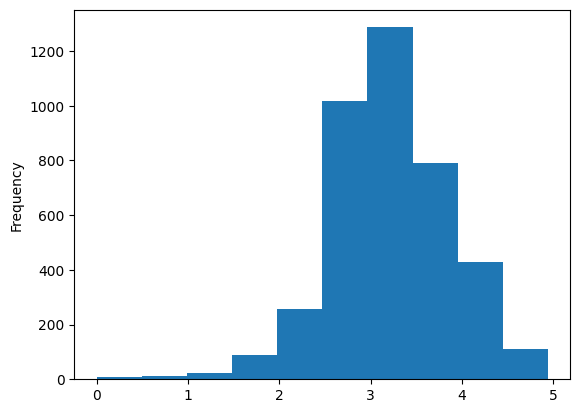

In [688]:
df['Tumor Size'] = df['Tumor Size'].apply('log')
df['Tumor Size'].plot.hist()

## Train Test Split

In [689]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Outlier Detection

<Axes: ylabel='Frequency'>

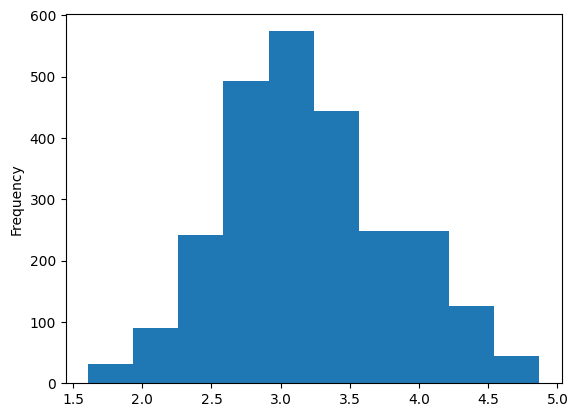

In [690]:
# Calculate the IQR range
Q1 = X_train['Tumor Size'].quantile(0.25)
Q3 = X_train['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = (X_train['Tumor Size'] < lower_bound) | (X_train['Tumor Size'] > upper_bound)

# Remove outliers from 'Tumor Size'
X_train = X_train[~outliers_tumor_size]
y_train = y_train[~outliers_tumor_size]

X_train['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

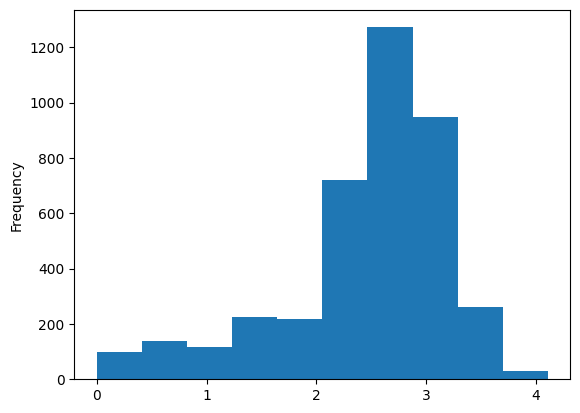

In [691]:
# Calculate the IQR range
Q1 = X_train['Regional Node Examined'].quantile(0.25)
Q3 = X_train['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = (X_train['Regional Node Examined'] < lower_bound) | (X_train['Regional Node Examined'] > upper_bound)

# Remove outliers from 'Regional Node Examined'
X_train = X_train[~outliers_regional_node]
y_train = y_train[~outliers_regional_node]

df['Regional Node Examined'].plot.hist()

## Preprocessing

In [692]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Data Balancing

In [693]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2006, 1: 368})


In [694]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1626, 0: 1304})


## Support Functions

In [695]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [696]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## LDA

In [697]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.82764,0.561265,0.461039,0.717172,0.39011


In [698]:
# Confusion matrix
confusion(y_val, y_pred_lda)

predicted,0,1
target,,
0,462,83
1,28,71


In [699]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.718312,0
1,-0.676176,0
2,-2.641853,0
3,-0.600908,0
4,-1.698048,0
...,...,...
2925,0.938795,1
2926,1.684215,1
2927,-0.375820,1
2928,-0.531495,1


<Axes: xlabel='0'>

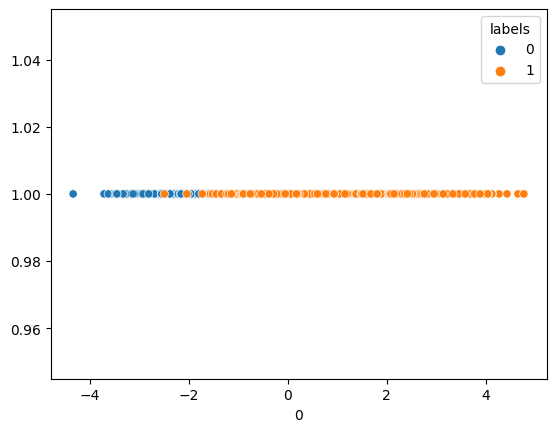

In [700]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [701]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   9   0.661491  0.401099  0.275472  0.737374  0.250859
      15  0.670807  0.407821  0.281853  0.737374   0.25614
      13  0.675466  0.407932  0.283465  0.727273  0.256228
      17   0.67236  0.405634   0.28125  0.727273  0.254417
      7   0.673913  0.403409  0.280632  0.717172  0.252669
      11  0.678571  0.406877     0.284  0.717172  0.255396
      19  0.675466  0.404558  0.281746  0.717172  0.253571
      21  0.666149  0.397759  0.275194  0.717172  0.248252
      23  0.673913  0.403409  0.280632  0.717172  0.252669
      5   0.675466  0.401146      0.28  0.707071  0.250896
      47  0.673913       0.4  0.278884  0.707071      0.25
      43  0.673913       0.4  0.278884  0.707071      0.25
      41  0.670807  0.397727   0.27668  0.707071  0.248227
      39  0.669255  0.396601  0.275591  0.707071   0.24735
      25  0.669255  0.393162   0.27381   0.69697  0.2446

In [702]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df.sort_values(by='Recall', ascending=False)

k value of the first row: 9


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.82764,0.561265,0.461039,0.717172,0.39011
KNN-9,0.661491,0.401099,0.275472,0.737374,0.250859


In [703]:
# Confusion matrix
confusion(y_val, y_pred_knn)

predicted,0,1
target,,
0,353,192
1,26,73


## Logistic Regression

In [704]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.759317  0.501608  0.367925  0.787879  0.334764
       1.0       0.798137  0.528986  0.412429  0.737374  0.359606
       100000.0  0.802795   0.51711  0.414634  0.686869  0.348718
       10000.0   0.802795   0.51711  0.414634  0.686869  0.348718
       1000.0    0.802795   0.51711  0.414634  0.686869  0.348718
       100.0     0.802795   0.51711  0.414634  0.686869  0.348718
       10.0      0.796584  0.509363  0.404762  0.686869  0.341709


In [705]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.759317,0.501608,0.367925,0.787879,0.334764
KNN-9,0.661491,0.401099,0.275472,0.737374,0.250859
LDA,0.82764,0.561265,0.461039,0.717172,0.39011


In [706]:
# Confusion matrix
confusion(y_val, y_pred_logreg)

predicted,0,1
target,,
0,411,134
1,21,78


## Random Forest

In [707]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9840018876828693


In [708]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.759317,0.501608,0.367925,0.787879,0.334764
Random Forest,0.807453,0.544118,0.427746,0.747475,0.373737
KNN-9,0.661491,0.401099,0.275472,0.737374,0.250859
LDA,0.82764,0.561265,0.461039,0.717172,0.39011


In [709]:
# Confusion matrix
confusion(y_val, y_pred_rf)

predicted,0,1
target,,
0,446,99
1,25,74


## Feature Importance

<Axes: >

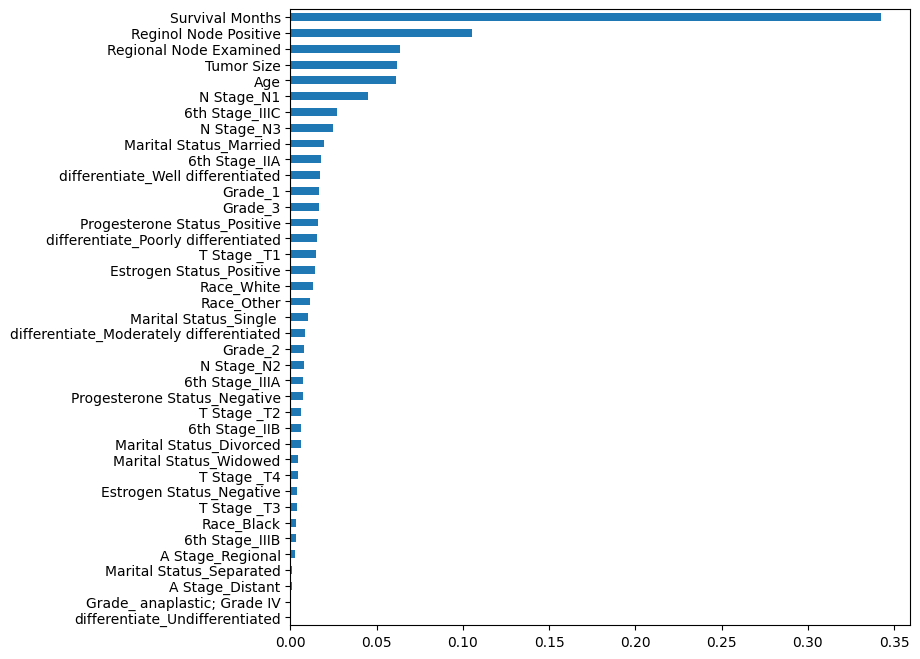

In [710]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [711]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [712]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7416149068322981
recall_score:  0.7398373983739838
jaccard_score:  0.30434782608695654
f1_score:  0.4666666666666667
precision_score:  0.3408239700374532
